In [77]:
"""Use a traditional neural network setup to classify plural class."""

from re import sub
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import one_hot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from matplotlib import pyplot as plt

In [78]:
"""Read features.txt and initialize feature dictionaries. Adapated from Brandon's LSTM code."""

def get_strings(data_file):
  """Process input file into a list of strings."""
  input_file = open(data_file)
  input_file.readline() # Skip first line
  UR_strings, SR_strings, syll_lengths = [], [], []
  ur_num = 0

  for line in input_file.readlines():
    columns = line.rstrip().split(",")
    if len(columns) == 2:
      ur, sr = columns
      if sr == "" or ur == "":
        continue
      ur_num += 1

      syll_lengths.append(len([seg for seg in ur.split(" ") if seg != ""]))
      UR_strings.append(ur)
      SR_strings.append(sr[-5:]) # Last 5 characters correspond to plural suffix
    else:
       print(line)
       raise Exception("Training data error! All lines should have 2 columns in TD files!")
  input_file.close()

  return UR_strings, SR_strings, syll_lengths

def get_arrays(UR_strings, SR_strings, syll_lengths, symbol2feats, suffix2label, override_max_syll=0):
  if override_max_syll:
    assert override_max_syll > max(syll_lengths)
    max_len = override_max_syll
  else: 
    max_len = max(syll_lengths)
  
  X_list = []
  Y_list = []
  padding_strs = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["_"]*(max_len-syll_length))
    this_ur = UR_strings[word_index]+" "+padding # Singular form + padding as string
    padding_strs.append(this_ur)
    this_sr = SR_strings[word_index][-5:] # Suffix as string

    #Fix some errors in data files:
    this_ur = sub(" J ", " Y ", this_ur)
    this_ur = sub(" C ", " CH ", this_ur)

    X_list.append([symbol2feats[seg] for seg in this_ur.split(" ") if seg != ""])
    Y_list.append(suffix2label[this_sr])

  X = np.array(X_list)
  Y = np.array(Y_list)

  return X, Y


In [79]:
"""Implements a pooling function to pool together phonetic feature vectors from different segments into a representative embedding vector."""

# Pooling function 

def pool_average(X):
    """Pools phonetic feature vectors by averaging across all segments."""
    # X.shape (n, 5, 19)
    return np.mean(X, axis=1)

def pool_sum(X):
    """Pools phonetic feature vectors by summation across all segments."""
    return np.sum(X, axis=1)

def pool_last(X):
    """Pools phonetic feature vectors by only returning the final segment."""
    last = X[:, -1, :]
    return last

def pool_concat(X):
	"""Pools features by concat each features vector head-to-tail. Results in a word-level feature vector of 5x19"""
	return np.array([np.concatenate(submatrices, axis=0) for submatrices in X])


In [80]:
"""Defines FFN model"""

# Define the FFN model
class SimpleFFN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [81]:
"""Load training data and fit logistic regression model"""

FEATURES_FILE = "featsNew"
TRAINING_DATA_FOLDER = "MinDefault"
FILE_PREFIX = "minDefault"

TRAINING_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_train.txt"
POOLING_FUNC = pool_concat # TODO change pooling function

#inputs
feat_file = open(FEATURES_FILE, "r")
feat_names = feat_file.readline().rstrip().split("\t")[1:] # Skip first space
symbol2feats = {'_': [0.0 for f in feat_names]}

for line in feat_file.readlines():
  columns = line.rstrip().split("\t")
  seg = columns[0]
  values = [{"-":-1.0, "+":1.0, "0":0.0}[v] for v in columns[1:]]
  symbol2feats[seg] = values

print(len(symbol2feats))
print(symbol2feats.keys())
print(len(symbol2feats["_"]))

#outputs
suffix2label = {
	"Y IY0": 0, #yee
	"W AH0": 1, #wuh
	"L EY0": 2 #lay
	}

URs, SRs, Ls = get_strings(TRAINING_DATA)
X, y = get_arrays(URs, SRs, Ls, symbol2feats, suffix2label)

print(X.shape)
X = POOLING_FUNC(X)
print(X.shape)
# Split the dataset into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = one_hot(torch.tensor(y_train).to(torch.int64), num_classes=3).to(torch.float32)


# Prepare data loaders
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[-1] # TODO make variable

print(input_dim)
hidden_dim = 100
output_dim = 3

model = SimpleFFN(input_dim, hidden_dim, output_dim)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


44
dict_keys(['_', 'P', 'B', 'T', 'D', 'K', 'G', 'NG', 'M', 'N', 'L', 'F', 'V', 'S', 'Z', 'SH', 'ZH', 'CH', 'JH', 'IH0', 'EH0', 'AH0', 'UH0', 'IY0', 'UW0', 'EY0', 'OW0', 'IH1', 'EH1', 'AH1', 'UH1', 'IY1', 'UW1', 'EY1', 'OW1', 'IH2', 'EH2', 'AH2', 'UH2', 'IY2', 'UW2', 'EY2', 'OW2', 'H'])
19
(1186, 5, 19)
(1186, 95)
95
Epoch [1/10], Loss: 0.0346
Epoch [2/10], Loss: 0.0082
Epoch [3/10], Loss: 0.0406
Epoch [4/10], Loss: 0.0044
Epoch [5/10], Loss: 0.0017
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0001


In [82]:
def get_plot(y_test, y_pred, title):
	"""
		"Y IY0": 0, #yee blue
		"W AH0": 1, #wuh green
		"L EY0": 2 #lay pink
	"""

	label2seg = {0: "Y IY0", 1: "W AH0", 2: "L EY0"}
	data = {
		"Y IY0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0},
		"W AH0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0},
		"L EY0": {"Y IY0": 0, "W AH0": 0, "L EY0": 0}
	}
	for gold_label, guess_label in zip(y_test, y_pred):
		gold = label2seg[gold_label]
		guess = label2seg[guess_label]
		data[gold][guess] += 1

	df = pd.DataFrame(data)
	df = df.T
	df ['sum'] = df.sum(axis=1)
	df.sort_values('sum', ascending=False)[['Y IY0','W AH0', 'L EY0']].plot.bar(rot=0, title=title, width=1) 
	plt.xlabel("Gold Class")
	plt.ylabel("Counts grouped by Predicted Class")
	plt.show()

In [83]:
# Define the inference function
def inference(model, inputs):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for inference
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        predictions_index = torch.argmax(predictions, dim=1)
    return predictions_index

X_valid = torch.tensor(X_valid, dtype=torch.float32)

# Perform inference
y_pred = inference(model, X_valid)
class_report = classification_report(y_valid, y_pred)
print(class_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       100

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



              precision    recall  f1-score   support

           0       1.00      0.98      0.99        96
           1       0.98      1.00      0.99        96
           2       1.00      1.00      1.00        96

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



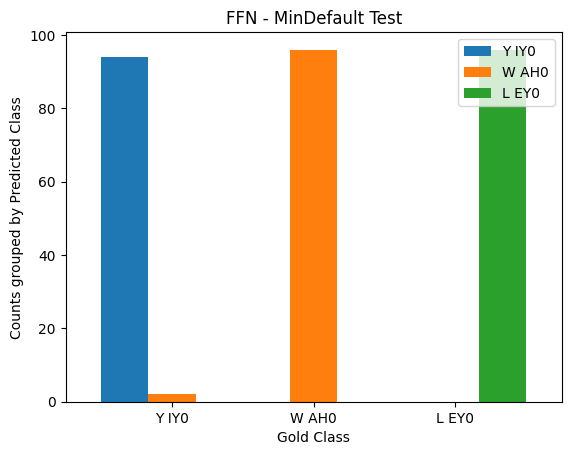

In [84]:
"""Evaluate test set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors
X_test = torch.tensor(X_test, dtype=torch.float32)

y_test_one_hot = one_hot(torch.tensor(y_test).to(torch.int64), num_classes=3).to(torch.float32)

y_pred = inference(model, X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test.tolist(), y_pred.tolist(), title=f"FFN - {TRAINING_DATA_FOLDER} Test")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        32

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



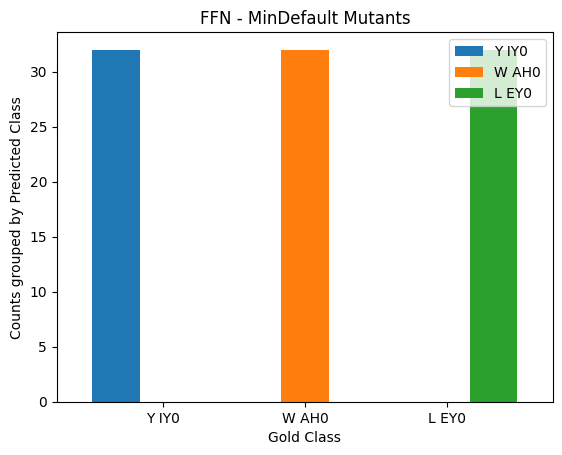

In [85]:
"""Evaluate test mutant set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_Mutants.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors
X_test = torch.tensor(X_test, dtype=torch.float32)

y_test_one_hot = one_hot(torch.tensor(y_test).to(torch.int64), num_classes=3).to(torch.float32)

y_pred = inference(model, X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test.tolist(), y_pred.tolist(), title=f"FFN - {TRAINING_DATA_FOLDER} Mutants")

0.5208333333333334


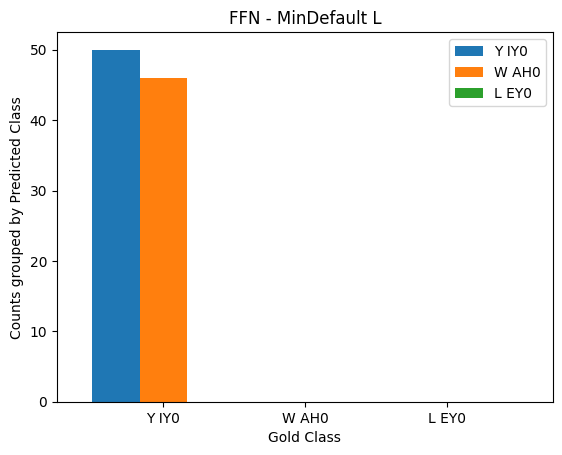

In [86]:
"""Evaluate test liquids set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_L.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors
X_test = torch.tensor(X_test, dtype=torch.float32)

y_test_one_hot = one_hot(torch.tensor(y_test).to(torch.int64), num_classes=3).to(torch.float32)

y_pred = inference(model, X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
# Can't use classification matrix because only one gold class.

get_plot(y_test.tolist(), y_pred.tolist(), title=f"FFN - {TRAINING_DATA_FOLDER} L")

              precision    recall  f1-score   support

           0       0.52      0.53      0.52        60
           1       0.34      0.38      0.36        40
           2       0.74      0.62      0.68        40

    accuracy                           0.51       140
   macro avg       0.53      0.51      0.52       140
weighted avg       0.53      0.51      0.52       140



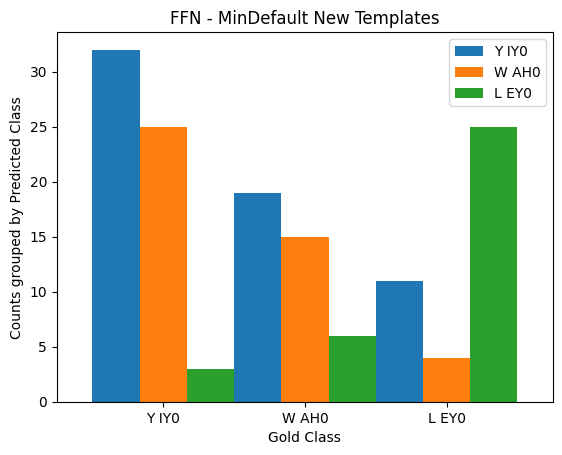

In [87]:
"""Evaluate test new templates set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_testNewTemplates.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors
X_test = torch.tensor(X_test, dtype=torch.float32)

# Need to pad X_test
padded_X_test = []
for dp in X_test:
    padding_length = input_dim - len(dp)
    padding = [0.0]*padding_length
    padded_dp = dp.tolist() + padding
    padded_X_test.append(padded_dp)

X_test = torch.tensor(padded_X_test, dtype=torch.float32)
y_test_one_hot = one_hot(torch.tensor(y_test).to(torch.int64), num_classes=3).to(torch.float32)

y_pred = inference(model, X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test.tolist(), y_pred.tolist(), title=f"FFN - {TRAINING_DATA_FOLDER} New Templates")

c:\Users\tniu\AppData\Local\miniconda3\envs\llm-base\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tniu\AppData\Local\miniconda3\envs\llm-base\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tniu\AppData\Local\miniconda3\envs\llm-base\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      40.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



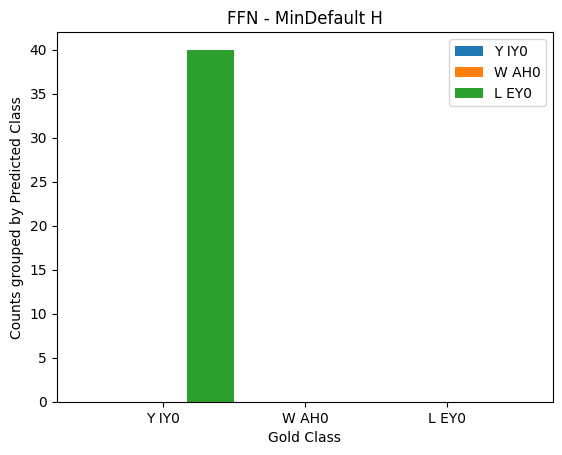

In [88]:
"""Evaluate test H set"""
TEST_DATA = f"./{TRAINING_DATA_FOLDER}/{FILE_PREFIX}_test_H.txt"

test_SGs, test_PLs, test_Ls = get_strings(TEST_DATA)
X_test, y_test = get_arrays(test_SGs, test_PLs, test_Ls, symbol2feats, suffix2label)

X_test = POOLING_FUNC(X_test) # TODO Pool feature vectors
X_test = torch.tensor(X_test, dtype=torch.float32)

# Need to pad X_test
padded_X_test = []
for dp in X_test:
    padding_length = input_dim - len(dp)
    padding = [0.0]*padding_length
    padded_dp = dp.tolist() + padding
    padded_X_test.append(padded_dp)

X_test = torch.tensor(padded_X_test, dtype=torch.float32)
y_test_one_hot = one_hot(torch.tensor(y_test).to(torch.int64), num_classes=3).to(torch.float32)

y_pred = inference(model, X_test)

class_report = classification_report(y_test, y_pred)
print(class_report)

get_plot(y_test.tolist(), y_pred.tolist(), title=f"FFN - {TRAINING_DATA_FOLDER} H")
